In [4]:
#IMPORT MODULES#

In [ ]:
%matplotlib inline
import pandas as pd
import sys
import numpy as np
import datetime
import seaborn as sns

In [5]:
#import ML models

from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier


In [2]:
from IPython.core.display import HTML
css = open('../Data/style-table.css').read() + open('../Data/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [ ]:
#IMPORT DATA#

In [6]:
#imports the raw data in chunks. SQL export to csv could not accomodate one CSV dump

USMTO1 = pd.DataFrame.from_csv('../Data/USMTO1.norm.csv', index_col = False)
USMTO2 = pd.DataFrame.from_csv('../Data/USMTO2.norm.csv', index_col = False)
USMTO3 = pd.DataFrame.from_csv('../Data/USMTO3.norm.csv', index_col = False)
USMTO4 = pd.DataFrame.from_csv('../Data/USMTO4.norm.csv', index_col = False)
USMTO5 = pd.DataFrame.from_csv('../Data/USMTO5.norm.csv', index_col = False)

In [7]:
#imports raw data for S&P 500 values and Industrial Production

SP_500 = pd.DataFrame.from_csv('../Data/SP_500.csv', index_col = False)

In [8]:
#re-combines raw data

USMTO_WHOLE = USMTO1.append(USMTO2).append(USMTO3).append(USMTO4).append(USMTO5)

In [9]:
#merges external data with USMTO data

USMTO_WHOLE = USMTO_WHOLE.merge(SP_500, how='inner', on = ['EntryMonth', 'EntryYear'])

In [10]:
#format order date to datetime to prepare for analysis

USMTO_WHOLE['OrderDateFormatted'] = pd.to_datetime(USMTO_WHOLE.OrderDate)

In [11]:
#format changed date to datetime to prepare for analysis

USMTO_WHOLE['ChangedDateFormatted'] = pd.to_datetime(USMTO_WHOLE.ChangedDate)

In [12]:
#format submit date to datetime to prepare for analysis

USMTO_WHOLE['SubmitDateFormatted'] = pd.to_datetime(USMTO_WHOLE.SubmitDate.fillna(''))

In [13]:
#more formatting to get Order Date at End of Month

USMTO_WHOLE['hyphen'] = "-"

USMTO_WHOLE['OrderDateEOM'] = (USMTO_WHOLE.EntryYear.astype(str)) + (USMTO_WHOLE.hyphen) + (USMTO_WHOLE.EntryMonth.astype(str)) + (USMTO_WHOLE.hyphen) + (USMTO_WHOLE.OrderDateFormatted.dt.days_in_month.astype(str))

In [14]:
#format OrderDateEOM to datetime

USMTO_WHOLE['OrderDateEOM'] = pd.to_datetime(USMTO_WHOLE['OrderDateEOM'])


In [15]:
#create column DaysLate which indicates how many days late the order was submitted

USMTO_WHOLE['DaysLate'] = (USMTO_WHOLE['SubmitDateFormatted'] - USMTO_WHOLE['OrderDateEOM']).dt.days - 10

In [16]:
#fill all NaN with "0" -> count=141

USMTO_WHOLE['DaysLate'] = USMTO_WHOLE['DaysLate'].fillna('0')

In [17]:
#cast DaysLate and TotalSale as float64

USMTO_WHOLE['DaysLate'] = pd.to_numeric(USMTO_WHOLE['DaysLate'])
USMTO_WHOLE['TotalSale'] = (USMTO_WHOLE['TotalSale'].replace( '[\$,)]','', regex=True )
               .replace( '[(]','-',   regex=True ).astype(float))

In [18]:
#drop un-needed columns

USMTO_WHOLE = USMTO_WHOLE.drop('SubmitDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('OrderDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('ChangedDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsCancel', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('CancelOrderID', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('hyphen', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsMatch', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsIgnore', axis=1)


In [20]:
#creates columns IsEmailOne, IsEmailTwo, IsCall indicating when reminders are made for a member to submit

USMTO_WHOLE['IsEmailOne'] = USMTO_WHOLE['DaysLate'] >= 1
USMTO_WHOLE.IsEmailOne = USMTO_WHOLE.IsEmailOne.astype('int')       

USMTO_WHOLE['IsEmailTwo'] = USMTO_WHOLE['DaysLate'] >= 5
USMTO_WHOLE.IsEmailTwo = USMTO_WHOLE.IsEmailTwo.astype('int')    

USMTO_WHOLE['IsCall'] = USMTO_WHOLE['DaysLate'] >= 10
USMTO_WHOLE.IsCall = USMTO_WHOLE.IsCall.astype('int')

USMTO_WHOLE['IsBackfill'] = USMTO_WHOLE['DaysLate'] >= 90
USMTO_WHOLE.IsBackfill = USMTO_WHOLE.IsBackfill.astype('int')

USMTO_WHOLE.to_csv('../Data/Intermediate.csv')

#caches the data

In [6]:
#import from cache to save time

USMTO_WHOLE = pd.DataFrame.from_csv('../Data/Intermediate.csv', index_col = False)

In [ ]:
#EXPLARATORY DATA ANALYSIS#

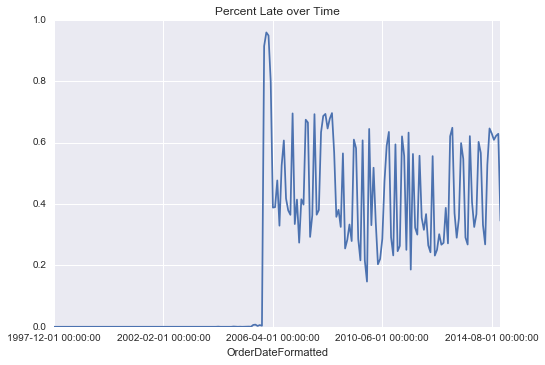

In [7]:
#shows the need to truncate data set and dump data before 2006

USMTO_WHOLE.groupby(['OrderDateFormatted'])['IsEmailOne'].mean().plot(kind = 'line', title = 'Percent Late over Time')

In [8]:
#tosses the former half of data which may not be relevant

USMTO_WHOLE = USMTO_WHOLE[(USMTO_WHOLE.OrderDateFormatted >= '2006-05-01')]

In [9]:
#shows columns of cleaned dataset

USMTO_WHOLE.columns

Index(['Unnamed: 0', 'OrderID', 'AAID', 'NAICSID', 'CustomerZipCode',
       'ShippingCountryID', 'ShippingZipCode', 'Units', 'TotalSale',
       'CreatedBy', 'CreateDate', 'ChangedBy', 'IsSubmitted',
       'TopCategoryName', 'SubCategory', 'SubCategoryName', 'Description',
       'MachineCode', 'EntryMonth', 'EntryYear', 'Date', 'Close', 'IP',
       'OrderDateFormatted', 'ChangedDateFormatted', 'SubmitDateFormatted',
       'OrderDateEOM', 'DaysLate', 'IsEmailOne', 'IsEmailTwo', 'IsCall',
       'IsBackfill'],
      dtype='object')

In [10]:
#create two new tables, one without outliers (outside 2 stdev), and one without backfillers (defined as submitted later than 100 days - per company definition)

USMTO_NO_SUBMIT_OUTLIERS = USMTO_WHOLE[np.abs(USMTO_WHOLE.DaysLate-USMTO_WHOLE.DaysLate.mean())<=(2*USMTO_WHOLE.DaysLate.std())] 
USMTO_NO_SUBMIT_BACKFILL = USMTO_WHOLE[USMTO_WHOLE.DaysLate <= 90]

#source: http://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-dataframe


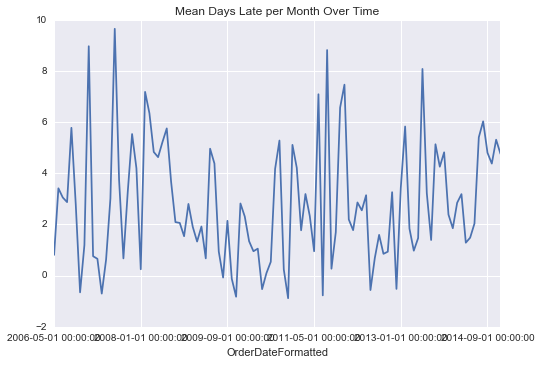

In [11]:
#Plots days late in a time series to see changes over time

USMTO_NO_SUBMIT_BACKFILL.groupby(['OrderDateFormatted'])['DaysLate'].mean().plot(kind = 'line', title = 'Mean Days Late per Month Over Time')

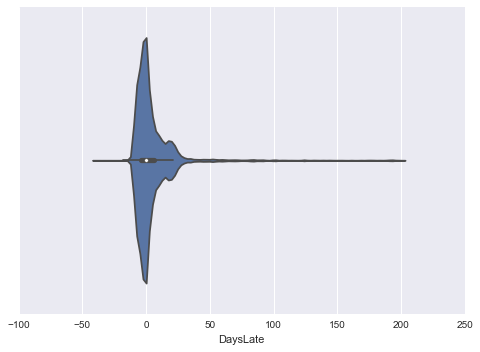

In [12]:
#plots distribution of days late - shows problem is not "endemic" but most rather participants are OK at submitting

sns.violinplot(USMTO_NO_SUBMIT_OUTLIERS.DaysLate, title = 'Distribution of Days Late, 1997 to present')


In [13]:
#Creates table that groups by AAID and OrderDateFormatted

AAID_BY_MONTH = USMTO_WHOLE.groupby(['AAID','OrderDateFormatted'])['DaysLate','TotalSale','IsEmailOne', 'IsEmailTwo', 'IsCall', 'IsBackfill','Close','IP'].mean()
AAID_BY_MONTH.reset_index(level=1, inplace=True)
AAID_BY_MONTH.reset_index(level=1, inplace=True)
AAID_BY_MONTH_2 = USMTO_WHOLE.groupby(['AAID','OrderDateFormatted'])['Units','TotalSale'].sum()
AAID_BY_MONTH_2.reset_index(level=1, inplace=True)
AAID_BY_MONTH_2.reset_index(level=1, inplace=True)
AAID_BY_MONTH = AAID_BY_MONTH.merge(AAID_BY_MONTH_2, how = 'inner', on = ['AAID','OrderDateFormatted'])
AAID_BY_MONTH['TotalSaleAvg'] = AAID_BY_MONTH['TotalSale_x']
AAID_BY_MONTH['TotalSale'] = AAID_BY_MONTH['TotalSale_y']
AAID_BY_MONTH = AAID_BY_MONTH.drop('TotalSale_x', axis = 1)
AAID_BY_MONTH = AAID_BY_MONTH.drop('TotalSale_y', axis = 1)
AAID_BY_MONTH.head()

AAID   OrderDateFormatted  DaysLate  IsEmailOne  IsEmailTwo  IsCall  \
0     123  2007-12-01 00:00:00     522.0           1           1       1   
1     123  2010-10-01 00:00:00     673.0           1           1       1   
2  100005  2006-05-01 00:00:00      -5.0           0           0       0   
3  100005  2006-06-01 00:00:00       1.0           1           0       0   
4  100005  2006-07-01 00:00:00      -8.0           0           0       0   

   IsBackfill        Close        IP  Units   TotalSaleAvg  TotalSale  
0           1  1468.359985  105.7256     13   18461.538462   240000.0  
1           1  1183.260010   95.6362      2  100000.000000   200000.0  
2           0  1270.089966  102.1531      7  131438.714286   920071.0  
3           0  1270.199951  102.5220      2  153945.500000   307891.0  
4           0  1276.660034  102.5057     11   57971.090909   637682.0

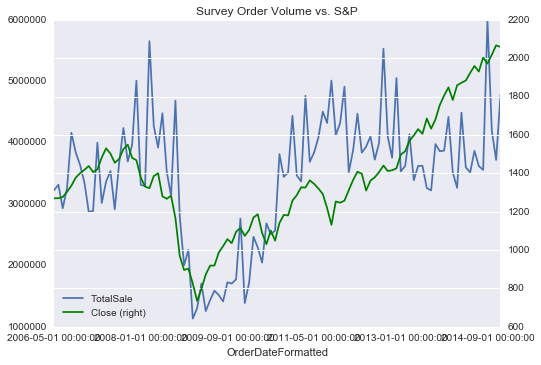

In [14]:
#shows similarity between survey orders and S&P

AAID_BY_MONTH.groupby(['OrderDateFormatted'])['TotalSale'].mean().plot(kind = 'line', legend ='true', title = 'Survey Order Volume vs. S&P')
AAID_BY_MONTH.groupby(['OrderDateFormatted'])['Close'].mean().plot(kind = 'line', secondary_y=True, legend = 'true', style= 'g')

AAID_BY_MONTH.plot?

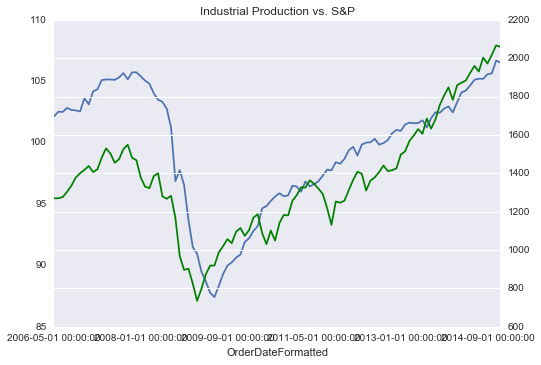

In [15]:
#shows similarity between IP and S&P

AAID_BY_MONTH.groupby(['OrderDateFormatted'])['IP'].mean().plot(kind = 'line', title = 'Industrial Production vs. S&P')
AAID_BY_MONTH.groupby(['OrderDateFormatted'])['Close'].mean().plot(kind = 'line', secondary_y=True, style= 'g')

In [16]:
#imports tables to work on, created from CreateAAIDByMonth

AAID_BY_MONTH_NO_BACKFILL = pd.DataFrame.from_csv('../Data/result.csv', index_col = False)
AAID_BY_MONTH_NO_BACKFILL = AAID_BY_MONTH_NO_BACKFILL.fillna(value = 0)

In [17]:
#shows columns of table we are about to work with

AAID_BY_MONTH_NO_BACKFILL.columns

Index(['Unnamed: 0', 'AAID', 'OrderDateFormatted', 'DaysLate', 'IsEmailOne',
       'IsEmailTwo', 'IsCall', 'IsBackfill', 'Close', 'IP', 'Units',
       'TotalSaleAvg', 'TotalSale', 'UnitsLast', 'IsCallLast',
       'TotalSaleAvgLast', 'TotalSaleLastThree', 'DaysLastLastThree',
       'DaysLateLast'],
      dtype='object')

In [76]:
#exports days late by aaid for further analysis internally

b = AAID_BY_MONTH_NO_BACKFILL.groupby(['AAID'])['DaysLate'].mean()
c = pd.DataFrame(b)
c.to_csv('../Data/DaysLateByAAID.csv',sep = ',')

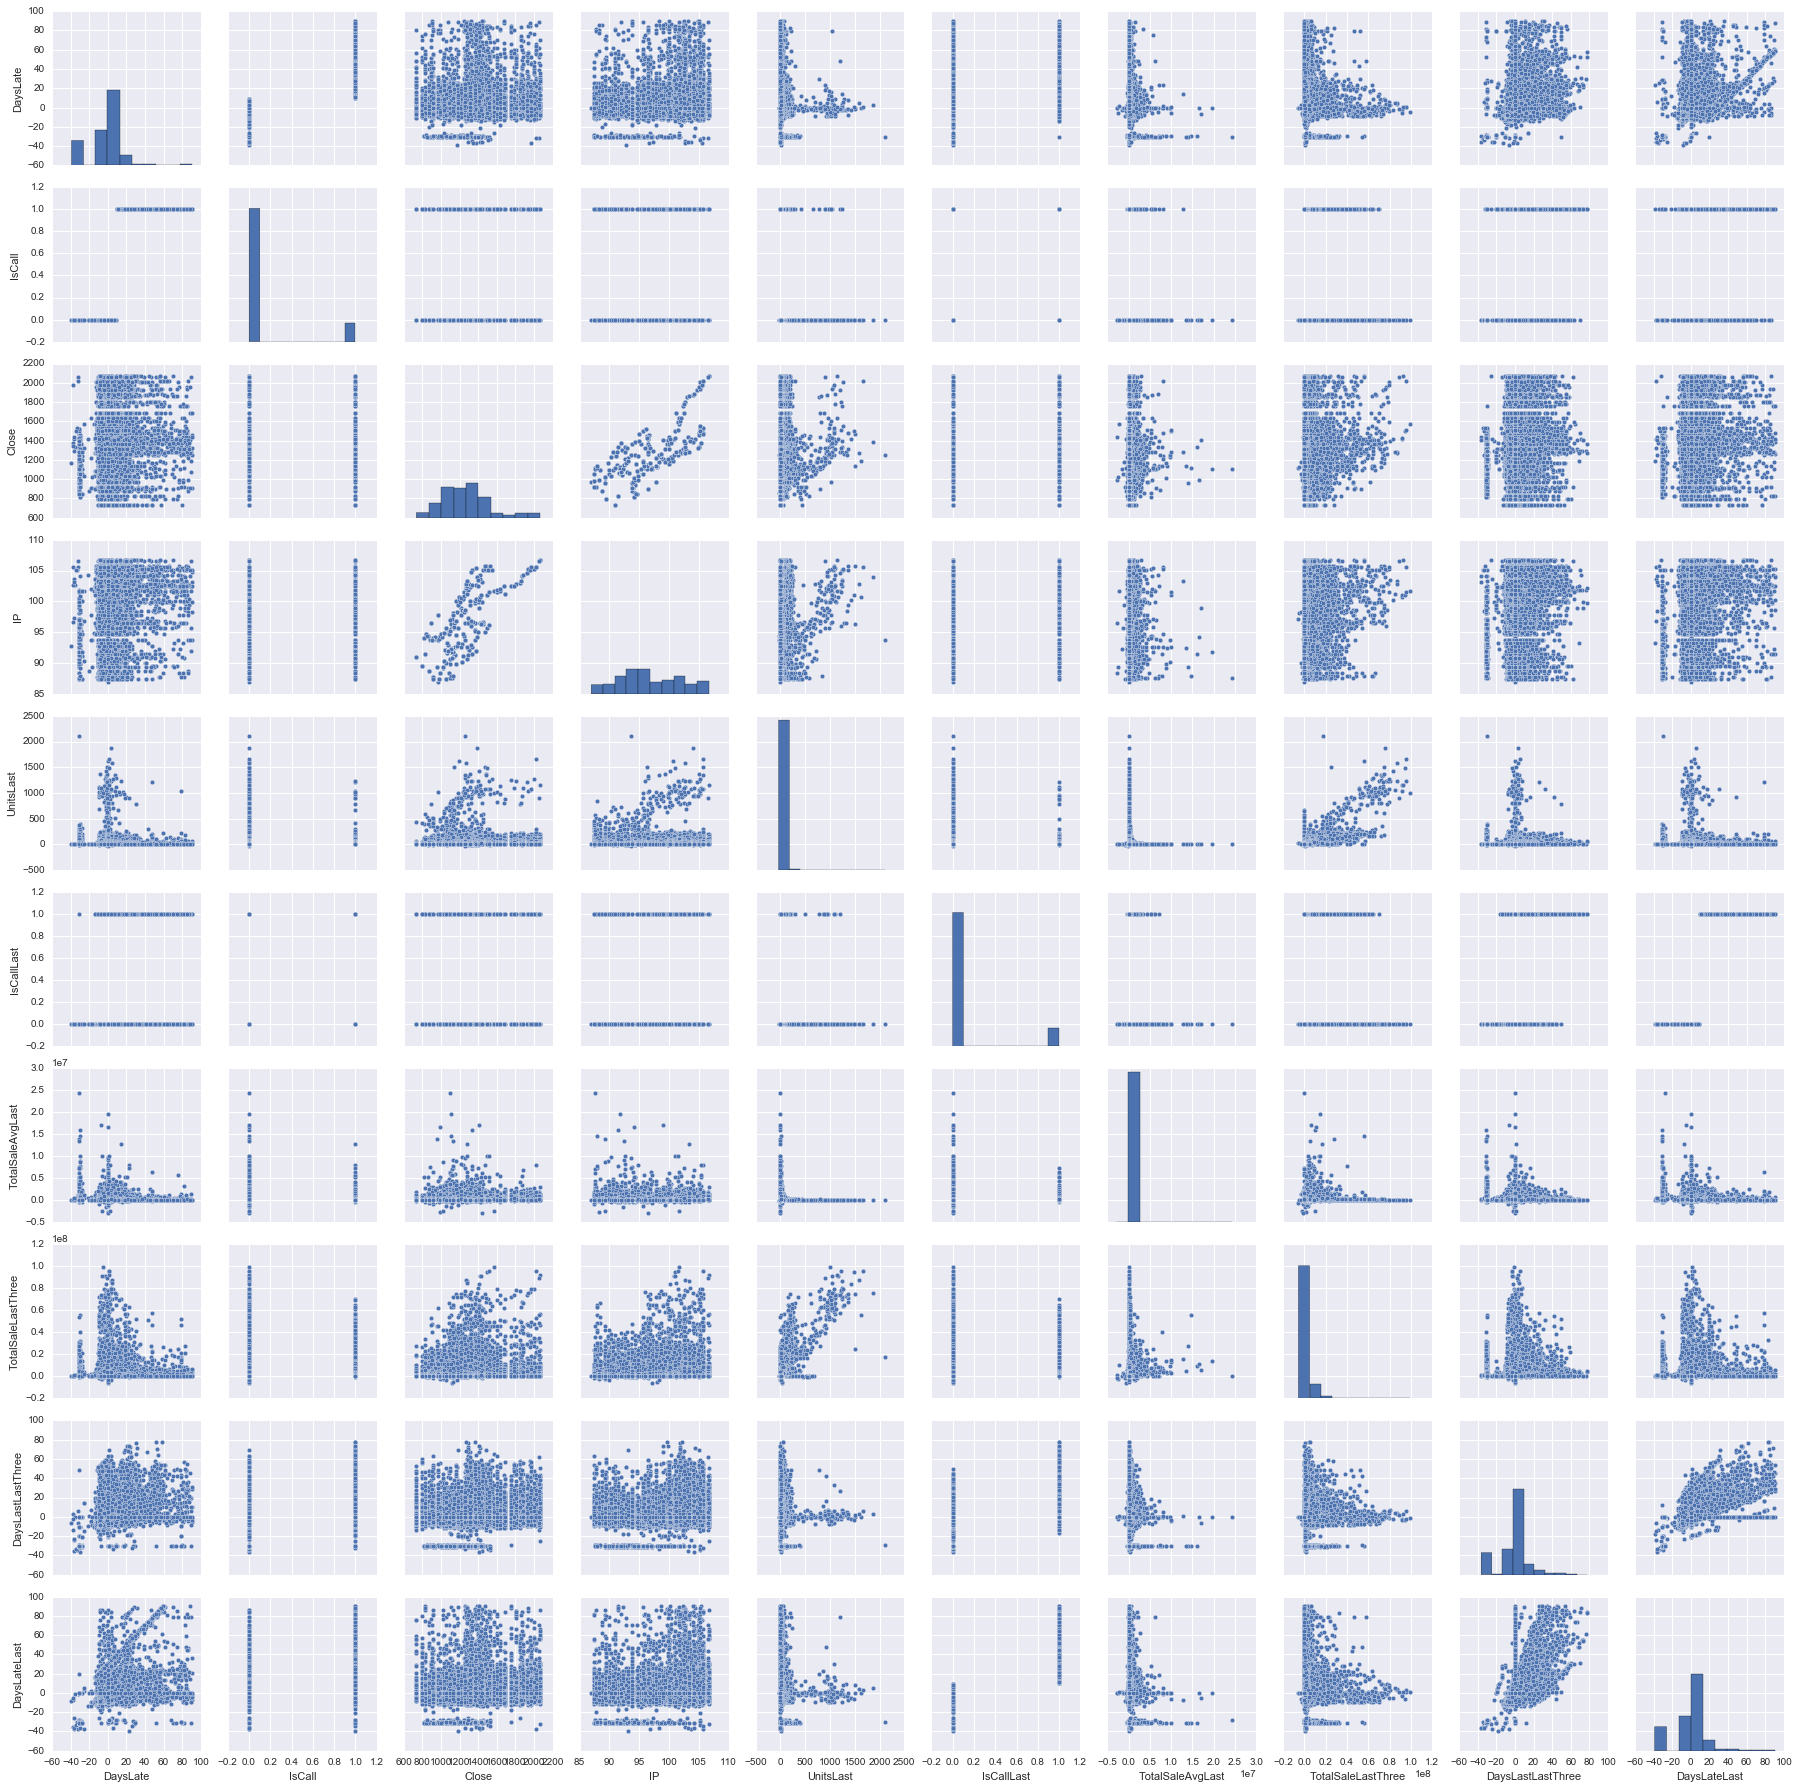

In [19]:
#scatter matrix identifying key features and their relationships - target excluded

PAIRPLOT2 = AAID_BY_MONTH_NO_BACKFILL
PAIRPLOT2 = PAIRPLOT2.drop('Unnamed: 0',axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('AAID', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('OrderDateFormatted', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailOne', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailTwo', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsBackfill', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSaleAvg', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('Units', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSale', axis = 1)

sns.pairplot(PAIRPLOT2)

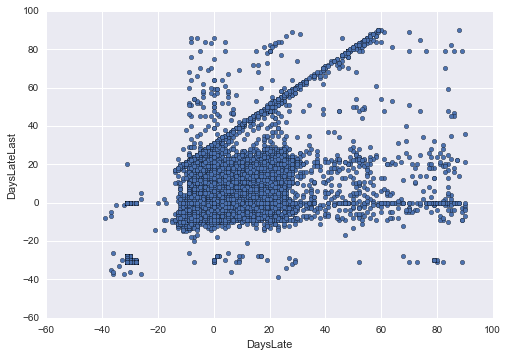

In [20]:
#DaysLate Last vs Days Late (suspicious line was investigated - business reason for this, not data error)

AAID_BY_MONTH_NO_BACKFILL.plot.scatter('DaysLate','DaysLateLast')

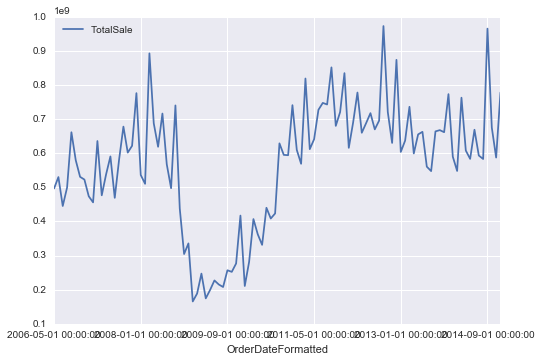

In [21]:
#average sales over time

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).sum()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='TotalSale')

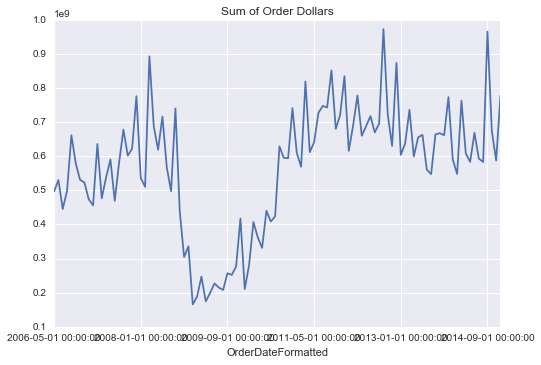

In [22]:
#plot of orders submitted over time

USMTO_WHOLE.groupby(['OrderDateFormatted'])['TotalSale'].sum().plot(kind = 'line', title = 'Sum of Order Dollars')

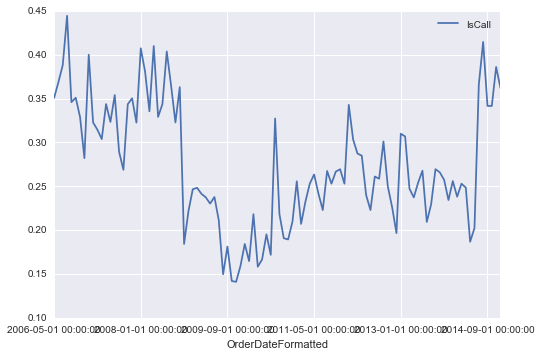

In [23]:
#percentage of company by month who needed to be called

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsCall')

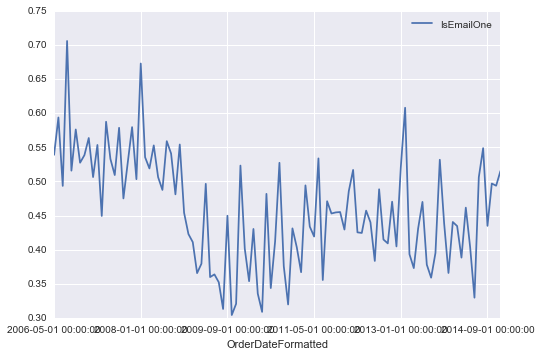

In [24]:
#percentage of company by month who needed to have first email sent

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsEmailOne')

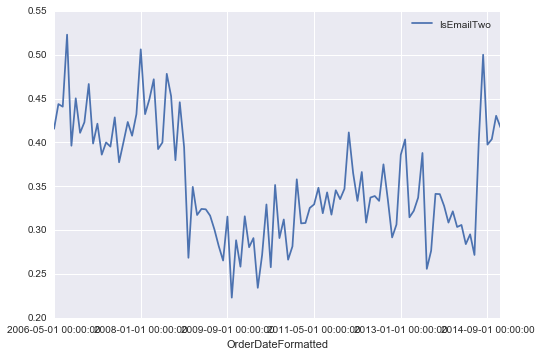

In [25]:
#percentage of company by month who needed to have second email sent

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsEmailTwo')

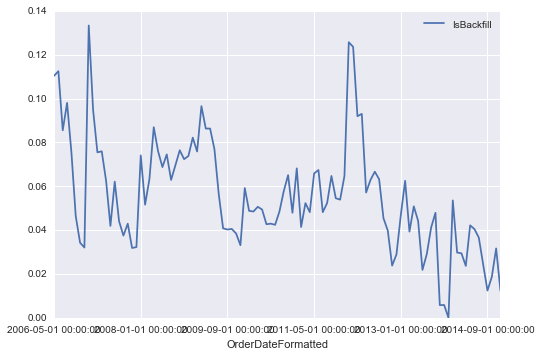

In [26]:
#percentage of company by month who backfilled

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsBackfill')

In [27]:
#shows columns we are working with in new dataset

PAIRPLOT2.columns

Index(['DaysLate', 'IsCall', 'Close', 'IP', 'UnitsLast', 'IsCallLast',
       'TotalSaleAvgLast', 'TotalSaleLastThree', 'DaysLastLastThree',
       'DaysLateLast'],
      dtype='object')

In [28]:
#prep for correlation matrix - target included. also the dataframe for machine learning algorithms

PAIRPLOT2 = AAID_BY_MONTH_NO_BACKFILL
PAIRPLOT2 = PAIRPLOT2.drop('AAID', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('OrderDateFormatted', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailOne', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailTwo', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsBackfill', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('DaysLate', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('DaysLateLast', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSaleAvg', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('Units', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSale', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('Unnamed: 0', axis = 1)

corr2 = PAIRPLOT2.corr(method = 'pearson')

In [29]:
#Class Distribution

AAID_BY_MONTH_NO_BACKFILL.groupby('IsCall').size()

IsCall
0    30225
1     4196
dtype: int64

In [30]:
#Skew of Attributes

PAIRPLOT2.skew()

IsCall                 2.311402
Close                  0.835570
IP                     0.102091
UnitsLast             13.460859
IsCallLast             2.356103
TotalSaleAvgLast      17.264811
TotalSaleLastThree     6.459864
DaysLastLastThree      0.000891
dtype: float64

In [31]:
#correlation matrix

PAIRPLOT2.corr()

IsCall     Close        IP  UnitsLast  IsCallLast  \
IsCall              1.000000  0.203681  0.303517   0.000187    0.545939   
Close               0.203681  1.000000  0.700408   0.053814    0.197086   
IP                  0.303517  0.700408  1.000000   0.063554    0.293172   
UnitsLast           0.000187  0.053814  0.063554   1.000000    0.002864   
IsCallLast          0.545939  0.197086  0.293172   0.002864    1.000000   
TotalSaleAvgLast    0.031652  0.034381  0.027511  -0.041987    0.030410   
TotalSaleLastThree  0.035714  0.108681  0.124087   0.747190    0.038466   
DaysLastLastThree   0.414792  0.157593  0.362939   0.040660    0.536899   

                    TotalSaleAvgLast  TotalSaleLastThree  DaysLastLastThree  
IsCall                      0.031652            0.035714           0.414792  
Close                       0.034381            0.108681           0.157593  
IP                          0.027511            0.124087           0.362939  
UnitsLast                  -0.041987            0.747190           0.040660  
IsCallLast                  0.030410            0.038466           0.536899  
TotalSaleAvgLast            1.000000            0.115792           0.005329  
TotalSaleLastThree          0.115792            1.000000           0.078496  
DaysLastLastThree           0.005329            0.078496           1.000000

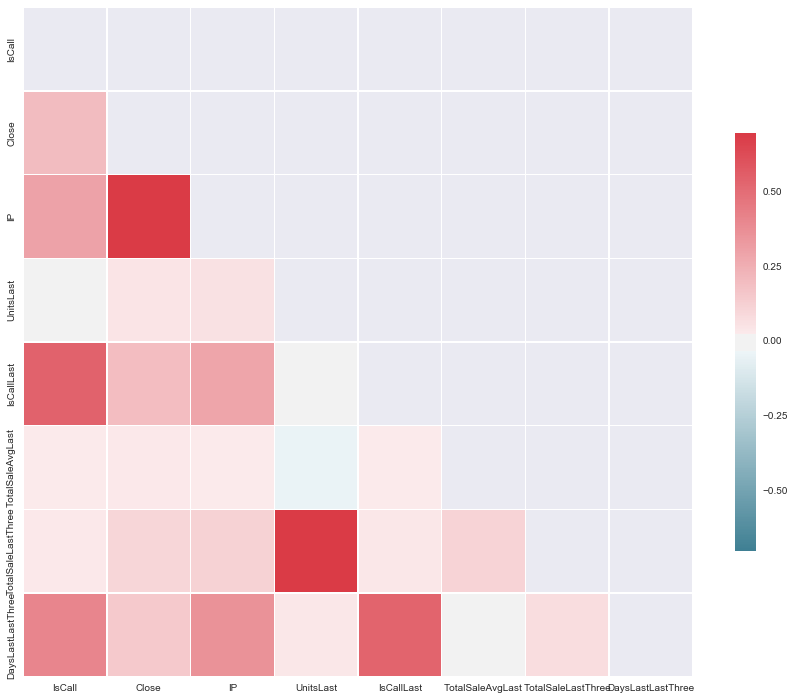

In [32]:
#Correlation Matrix Plot
import matplotlib.pyplot as plt

# Generate a mask for the upper triangle
mask = np.zeros_like(corr2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr2, mask=mask, cmap=cmap, vmax=.7,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)


In [33]:
#shows key characteristics of the dataset we will run through ML models

PAIRPLOT2.describe()

IsCall         Close            IP     UnitsLast    IsCallLast  \
count  34421.000000  34421.000000  34421.000000  34421.000000  34421.000000   
mean       0.121902   1271.352003     96.787987     19.318526      0.118823   
std        0.327178    258.753713      5.059148     69.135550      0.323585   
min        0.000000    735.090027     86.945400    -34.000000      0.000000   
25%        0.000000   1104.239990     92.951700      3.000000      0.000000   
50%        0.000000   1249.479980     96.256200      7.000000      0.000000   
75%        0.000000   1400.630005    101.224500     16.000000      0.000000   
max        1.000000   2067.560059    106.686800   2110.000000      1.000000   

       TotalSaleAvgLast  TotalSaleLastThree  DaysLastLastThree  
count      3.442100e+04        3.442100e+04       34421.000000  
mean       2.124751e+05        2.779693e+06          -2.257721  
std        4.786152e+05        6.270786e+06          14.556697  
min       -2.802056e+06       -5.691504e+06         -36.333333  
25%        5.937617e+04        3.823700e+05          -4.333333  
50%        1.194976e+05        1.056368e+06           0.000000  
75%        2.312968e+05        2.573025e+06           0.000000  
max        2.440000e+07        9.903093e+07          77.666667

In [ ]:
#FEATURE SELECTION#

In [34]:
# Feature Importance with Extra Trees Classifier

from sklearn.ensemble import ExtraTreesClassifier
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]

# feature importance - highest to lowest based on coefficient

model = ExtraTreesClassifier()
model.fit(X, Y)
print(model.feature_importances_)

[ 0.08432486  0.11002496  0.10632974  0.25713846  0.12196627  0.11970962
  0.20050608]


In [35]:
# Feature Extraction with RFE 

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# load data

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
# feature extraction
model = LogisticRegression()
rfe = RFE(model, 4)
fit = rfe.fit(X, Y)
print("Num Features: " , fit.n_features_)
print("Selected Features: " , fit.support_)
print("Feature Ranking: " , fit.ranking_)

Num Features:  4
Selected Features:  [ True  True False  True False False  True]
Feature Ranking:  [1 1 2 1 3 4 1]


In [36]:
#tags just the features for later use

a = pd.DataFrame({'Close':X[:,0],'IP':X[:,1],'UnitsLast':X[:,2],'IsCallLast':X[:,3],'TotalSaleAvgLast':X[:,4],'TotalSaleLastThree':X[:,5],'DaysLateLastThree':X[:,6]}).head()


In [37]:
#we end up using all features as there are not too many to begin with and no one feature appears to be terrible

In [ ]:
#MODELING#

In [61]:
#test different types of models without optimizing k and validation size - we see cart without any modifications is initially the best

array = PAIRPLOT2.values
X = array[:,1:14].astype(float)
Y = array[:,0]
validation_size = 0.33
seed = 7
X_train, X_validation, Y_train, Y_validation = cross_validation.train_test_split(X, Y,
test_size=validation_size, random_state=seed)
num_folds = 5
num_instances = len(X_train)
seed = 7
scoring = 'recall'
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('KNNWeighted', KNeighborsClassifier(weights='distance')))
models.append(('CART', DecisionTreeClassifier()))
models.append(('CART Max Depth 10', DecisionTreeClassifier(max_depth= 10)))
models.append(('NB', GaussianNB()))
results = []
names = []
for name, model in models:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = (name, cv_results.mean(),cv_results.std())
    print(msg)


('LR', 0.0, 0.0)
('LDA', 0.59647335316794525, 0.018913242510157705)
('KNN', 0.034439561171862691, 0.0062674458661953333)
('KNNWeighted', 0.072860622346177892, 0.0083632676454964659)
('CART', 0.51669484746046312, 0.016968373940717693)
('CART Max Depth 10', 0.50777676972089481, 0.031769427933193664)
('NB', 0.0, 0.0)


In [66]:
#test different types of models with optimal k and validation size - we see cart with max depth is now the best algorithm

array = PAIRPLOT2.values
X = array[:,1:14].astype(float)
Y = array[:,0]
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = cross_validation.train_test_split(X, Y,
test_size=validation_size, random_state=seed)
num_folds = 10
num_instances = len(X_train)
seed = 7
scoring = 'recall'
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('KNNWeighted', KNeighborsClassifier(weights='distance')))
models.append(('CART', DecisionTreeClassifier()))
models.append(('CART Max Depth 10', DecisionTreeClassifier(max_depth= 10)))
models.append(('NB', GaussianNB()))
results = []
names = []
for name, model in models:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = (name, cv_results.mean(),cv_results.std())
    print(msg)


('LR', 0.0, 0.0)
('KNN', 0.040960922043997552, 0.00717785572960638)
('KNNWeighted', 0.079999654975396503, 0.013306035192015389)
('CART', 0.50772129072848615, 0.01529025695035024)
('CART Max Depth 10', 0.53081744292845612, 0.030909844872826851)
('NB', 0.0, 0.0)


In [41]:
#generate table to determine optimal max depth

array = PAIRPLOT2.values
X = array[:,1:14].astype(float)
Y = array[:,0]
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = cross_validation.train_test_split(X, Y,
test_size=validation_size, random_state=seed)
num_folds = 10
num_instances = len(X_train)
seed = 7
depth = 1
scoring = 'recall'
models = []
results = []
names = []
scores = [0]
table = pd.DataFrame(columns = range(1))
for depth in range(1,31):
        models.append((('CART max depth:', depth), DecisionTreeClassifier(max_depth = depth)))
for name, model in models:
        kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
        cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        scores.append(cv_results.mean())
        msg = (name, cv_results.mean(),cv_results.std())
        print(msg)
        
table = table.append(scores)

(('CART max depth:', 1), 0.62144035877298465, 0.05435932874627436)
(('CART max depth:', 2), 0.48733125324216919, 0.066619834350352028)
(('CART max depth:', 3), 0.4608415450866219, 0.068158548100325775)
(('CART max depth:', 4), 0.52173868798877465, 0.048753950599479123)
(('CART max depth:', 5), 0.51151332437871744, 0.043360570658106487)
(('CART max depth:', 6), 0.51850540376299414, 0.03280605696554835)
(('CART max depth:', 7), 0.52427670982338914, 0.042713368341687999)
(('CART max depth:', 8), 0.52387220807514567, 0.034823276592955317)
(('CART max depth:', 9), 0.52174759703197349, 0.040693386286789902)
(('CART max depth:', 10), 0.53033954194335942, 0.031163680741042653)
(('CART max depth:', 11), 0.52400255456405098, 0.030844002617282304)
(('CART max depth:', 12), 0.52388833701890458, 0.016286374186771074)
(('CART max depth:', 13), 0.51971381020467111, 0.025132832879426407)
(('CART max depth:', 14), 0.52173031129081238, 0.023087340840272648)
(('CART max depth:', 15), 0.52544051752514009,

In [42]:
#generate table to determine optimal leaf size

array = PAIRPLOT2.values
X = array[:,1:14].astype(float)
Y = array[:,0]
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = cross_validation.train_test_split(X, Y,
test_size=validation_size, random_state=seed)
num_folds = 10
num_instances = len(X_train)
seed = 7
depth = 1
scoring = 'recall'
models = []
results_leaf = []
names = []
scores = [0]
leaf_size_table = pd.DataFrame(columns = range(1))
for leaf in range(1,31):
        models.append((('CART min leaf size:', leaf*200), DecisionTreeClassifier(min_samples_leaf= leaf*200)))
for name, model in models:
        kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
        cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        results_leaf.append(cv_results)
        names.append(name)
        scores.append(cv_results.mean())
        msg = (name, cv_results.mean(),cv_results.std())
        print(msg)
        
leaf_size_table = leaf_size_table.append(scores)

(('CART min leaf size:', 200), 0.50166279468056563, 0.040516013927959053)
(('CART min leaf size:', 400), 0.49618518865501837, 0.047737736238599365)
(('CART min leaf size:', 600), 0.47505555166289437, 0.060184006477767761)
(('CART min leaf size:', 800), 0.45177968959392889, 0.063378923882484728)
(('CART min leaf size:', 1000), 0.46793724276528526, 0.077249093176447528)
(('CART min leaf size:', 1200), 0.4644988473498125, 0.079970019765332662)
(('CART min leaf size:', 1400), 0.39384974901534459, 0.039689681094809248)
(('CART min leaf size:', 1600), 0.52207820211853995, 0.074042389925509322)
(('CART min leaf size:', 1800), 0.52048584543064191, 0.075613505671134604)
(('CART min leaf size:', 2000), 0.62144035877298465, 0.05435932874627436)
(('CART min leaf size:', 2200), 0.62144035877298465, 0.05435932874627436)
(('CART min leaf size:', 2400), 0.62144035877298465, 0.05435932874627436)
(('CART min leaf size:', 2600), 0.62144035877298465, 0.05435932874627436)
(('CART min leaf size:', 2800), 0.

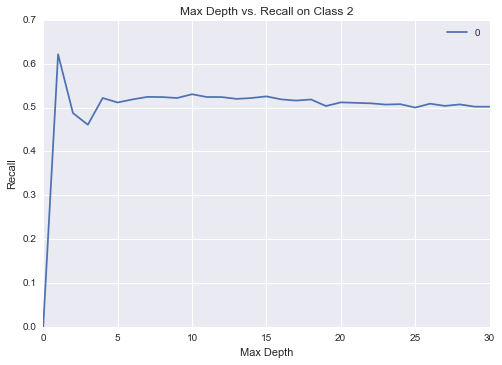

In [43]:
#plot max depth vs recall

depth_plot = table.plot(kind = 'line' ,title = 'Max Depth vs. Recall on Class 2')
depth_plot.set_xlabel("Max Depth")
depth_plot.set_ylabel("Recall")

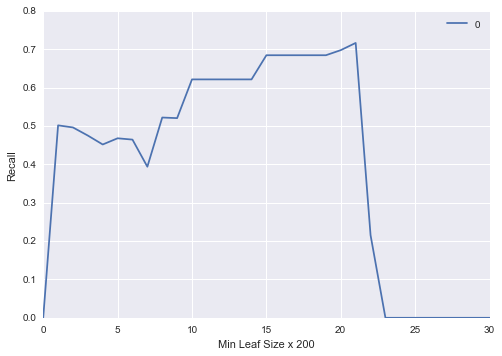

In [44]:
#plot min leaf size vs recall

leaf_plot = leaf_size_table.plot(kind = 'line',label = 'Min Leaf Size vs. Recall on Class 2')
leaf_plot.set_xlabel("Min Leaf Size x 200")
leaf_plot.set_ylabel("Recall")

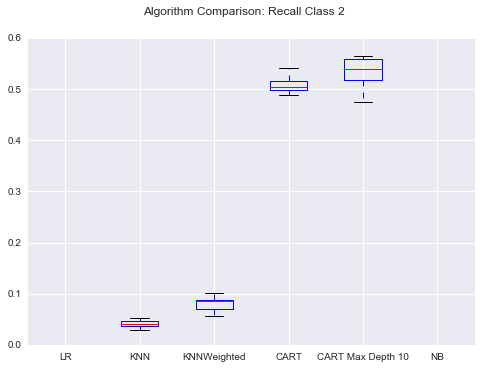

In [67]:
#distribution of models, accuracy and std dev

fig = plt.figure()
fig.suptitle('Algorithm Comparison: Recall Class 2')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [48]:
#exports decision tree for viewing - we see that it's massive and indicates overfitting

from sklearn import tree

clf = tree.ExtraTreeClassifier(max_depth=5)
clf = clf.fit(X_train, Y_train)
tree.export_graphviz(clf, out_file='decisiontree.dot',feature_names = a.columns)   

In [49]:
#exports decision tree for viewing - we see that it's massive and indicates overfitting

from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, Y_train)
tree.export_graphviz(clf, out_file='decisiontreebetter.dot',feature_names = a.columns)   

In [68]:
#classification report with kNN

from sklearn.metrics import classification_report

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = KNeighborsClassifier()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.88      0.98      0.93      9970
        1.0       0.24      0.04      0.07      1389

avg / total       0.80      0.87      0.82     11359



In [69]:
#classification report with kNN adjusted k

from sklearn.metrics import classification_report

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = KNeighborsClassifier(n_neighbors = 1)
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.88      0.89      0.89      9970
        1.0       0.16      0.15      0.16      1389

avg / total       0.79      0.80      0.80     11359



In [70]:
#classification report with CART 

from sklearn.metrics import classification_report

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = RandomForestClassifier(max_depth = 5)
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.94      0.97      0.95      9970
        1.0       0.71      0.52      0.60      1389

avg / total       0.91      0.91      0.91     11359



In [72]:
#classification report with CART with max depth of 10

from sklearn.metrics import classification_report

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = 0.2
seed = 10
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = DecisionTreeClassifier(max_depth = 10)
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.94      0.96      0.95      6058
        1.0       0.66      0.54      0.59       827

avg / total       0.91      0.91      0.91      6885



In [81]:
#classification report with CART with max depth of 10 and min samples/leaf of 4000

from sklearn.metrics import classification_report

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = 0.2
seed = 10
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = DecisionTreeClassifier(max_depth = 10, min_samples_leaf=4000)
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.96      0.93      0.94      6058
        1.0       0.56      0.70      0.62       827

avg / total       0.91      0.90      0.90      6885



In [74]:
#classification report with Logistic Regression

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = 0.2
seed = 7
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = LogisticRegression()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.88      1.00      0.94      6075
        1.0       0.00      0.00      0.00       810

avg / total       0.78      0.88      0.83      6885



C:\Users\Viu52790\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [75]:
#classification report with Naive Bayes

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = .2
seed = 7
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = GaussianNB()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.88      1.00      0.94      6075
        1.0       0.00      0.00      0.00       810

avg / total       0.78      0.88      0.83      6885



C:\Users\Viu52790\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [58]:
# ROC statistic for reference - indicates a "good" model by conventional standards
# source for "good": http://gim.unmc.edu/dxtests/roc3.htm

from sklearn import cross_validation
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
num_folds = 10
num_instances = len(X)
seed = 7
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
model = DecisionTreeClassifier(max_depth = 9)
scoring = 'roc_auc'
results = cross_validation.cross_val_score(model, X, Y, cv=kfold, scoring = scoring)
print("AUC: ", results.mean(), "      Std Dev: ", results.std()*100.0)


AUC:  0.890859411143       Std Dev:  6.03958226299


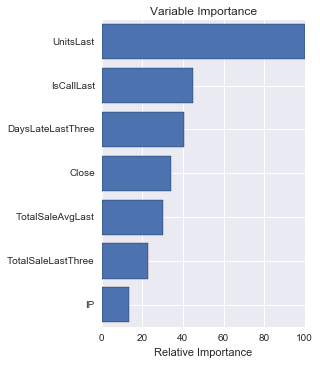

In [59]:
# Plot feature importance

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.01, 'loss': 'ls'}

clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, Y_train)

feature_importance = clf.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, a.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()